# p3. MNIST Classification via PCA Reconstruction

- 기수: 11기

- 이름: 한은결

- 작성자: 11기 김정우


_본 과제는 Songkuk Kim의 Programming for Data Science (IIT3308) 과제에 참조하였음을 밝힙니다._


PCA는 고차원 데이터의 특징을 최대한 보존하면서 차원을 낮추기 위한 방법인 Dimensionality Reduction의 대표적인 method 중 하나입니다.

PCA는 결과적으로 원본 데이터의 Variance를 최대한 보존할 수 있는 Principal Component들을 찾는 것을 목표로 합니다. 그리고 선정한 Principal Component들은 모두 일정한 Explained Variance를 갖게 됩니다.

각 Principal Component의 설명력은 Covariance의 관점에서 PCA를 살펴보면 알 수 있습니다.

결국 Covariance Matrix에 대한 Eigenvalue Decomposition을 수행한 결과로써 PCA를 해석할 수 있는데, 이때 설명력이 높은 순서는 Eigenvalue의 크기가 큰 순서와 동일합니다.

본 과제 문제에서는 이러한 PCA의 간단한 구현과 Explained Variance 시각화에 대한 내용, 그리고 더 나아가 Reconstruction Error를 기반으로 한 간단한 Classification Task를 다룹니다.


## 1. Introduction: What is Reconstruction Error?


- **Reconstruction Error란 PCA를 이용한 Dimensionality Reduction 이후 다시 Dimension을 원래대로 Reconstruction하는 과정에서 발생하는 오차를 의미합니다.**


<hr/>

Dimensionality Reduction은 결국 정보량의 손실 (압축) 입니다. 아무리 Variance가 높게 Principal Component를 잘 설정한다 하더라도 정보량의 손실은 불가피합니다.

724차원의 데이터에 PCA를 적용하면서 Principal Component의 개수 $N$ 을 $10, 100, 250$ 각각으로 설정함에 따라 축소된 차원에서 보존되는 정보량이 늘어나게 됩니다.

또한 $N = 724$ 로 설정하게 되면 PCA를 진행하더라도, Dimension은 축소되지 않으며, 곧 정보량 또한 손실되지 않습니다.


- **그렇다면 PCA Reconstruction이란 무엇인가요?**


<hr/>

Reduction을 거친 축소된 차원에서 다시 Principal Component를 사용한다면 원본 데이터를 복원할 수 있습니다. (PCA의 역연산)

그렇다면 Principal Component의 개수가 많을수록, 손실된 정보량이 적기 때문에 더욱 완벽한 원본 이미지를 복원할 수 있겠죠?


- **그렇다면 고양이에 대한 데이터들에 대해 구한 Principal Component로 오토바이의 사진을 복원한다면 어떻게 될까요?**


<hr/>

간단하게 오토바이와 고양이의 사진들로 구성된 데이터셋이 있다고 가정해봅시다. 고양이들의 사진을 기준으로 PCA를 진행하기 위해 Principal Component를 구했습니다.

동일한 Principal Component로 오토바이 사진에 대해 Dimensionality Reduction과 Reconstruction을 진행한다면 어떻게 될까요?


- **당연히 Reconstruction Error는 오토바이 사진보다 고양이 사진에서 훨씬 더 낮을 것입니다!**


<hr/>

본 과제에서는 이러한 특성을 이용해 각 라벨에 대한 Principal Component들을 구하고, 그를 기반으로 Reconstruction Error를 비교하여 라벨을 선택해보고자 합니다.


## 2. Load Dataset


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import seaborn as sns

In [2]:
# Load MNIST Dataset
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.values.astype(np.float32)
y = mnist.target.astype(int)

C:\Users\ekhan\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
print("Data Shape:", X.shape) # Data Shape
print("Label Shape:", y.shape) # Label Shape

Data Shape: (70000, 784)
Label Shape: (70000,)


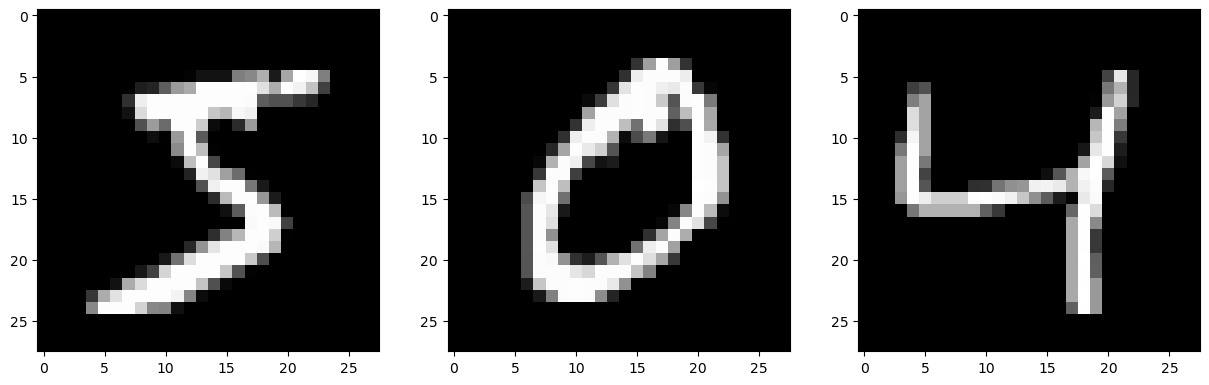

In [4]:
# Data Visualization
plt.figure(figsize=(15, 5))

for i in range(3):
  plt.subplot(1, 3, i+1)
  plt.imshow(X[i].reshape(28, 28), cmap='gray')

plt.show()

In [5]:
# Dataset pre-process: Normalization
def normalize_data(X):

    mean = np.mean(X, axis = 0)
    std = np.mean(X,axis=0)

    std[std == 0] = 1 # Avoid division by zero
    X_normalized = (X - mean) / std

    return X_normalized

X_normalized = normalize_data(X)

In [6]:
# Split into train/test set
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=2024)

In [7]:
# Check train/test set
print("Train Dataset Shape:", X_train.shape)
print("Test Dataset Shape:", X_test.shape)

Train Dataset Shape: (49000, 784)
Test Dataset Shape: (21000, 784)


_이어지는 과정에서 라벨별 데이터에 대한 Principal Component를 각각 생성하기 위해 Train Dataset은 라벨에 따라 분류해줍니다._

<hr/>


In [8]:
# Split train dataset into each labels
label_datasets_train = {label: X_train[y_train == label] for label in range(10)}

label_datasets_train[0].shape

(4815, 784)

## 3. Basic PCA


본 문제에서는 PCA 라이브러리가 아닌, 행렬 단위 연산을 통해 PCA 함수를 직접 구현하고자 합니다.

<hr/>


In [11]:
# PCA Function
def compute_pca(X, n_components): # X: Data Sampe (*, 784)  # n_components: Number of Principal Component

    # Get Covariance matrix
    covariance_matrix = np.cov(X.T)

    # Eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Sort eigenvectors by eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # Select the top n_components
    selected_eigenvectors = sorted_eigenvectors[:, :n_components]

    # Explained Variance
    explained_variance = sorted_eigenvalues[:n_components] / np.sum(sorted_eigenvalues)

    return selected_eigenvectors, explained_variance

In [12]:
# Example
pca_example1, explained_variance1 = compute_pca(X_train, 32) # Change PCA Feature Number

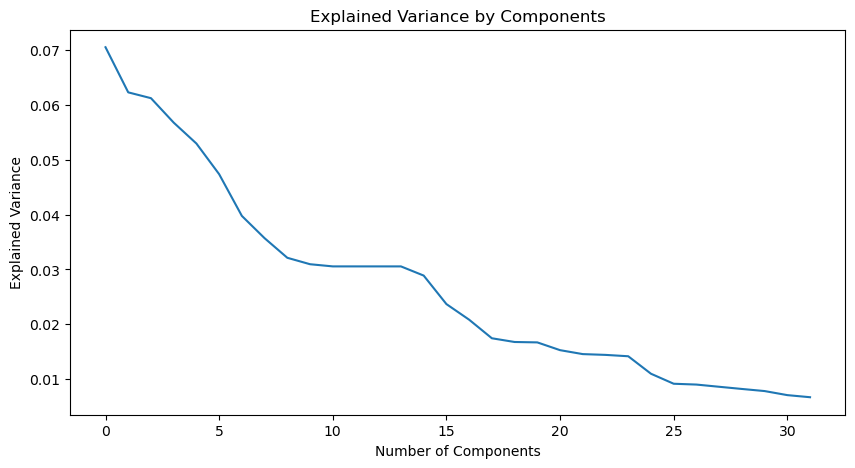

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(explained_variance1)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Components')
plt.show()

## 4. PCA Reconstruction


아래와 같이 PCA 기반으로 MNIST 데이터셋의 Dimension을 낮추고, 다시 복원하는 과정을 진행할 수 있습니다.

Original Image와 Reconstructed Image의 시각화에서 살펴볼 수 있듯, Reconstructed Image가 Original과 상당한 유사도를 갖게 됨을 확인할 수 있습니다.

<hr/>


**label_datasets_train의 idx와 해당 데이터셋 안에서의 idx값, principal component의 개수를 다양하게 바꿔보면서 실험해보세요!**


In [14]:
# PCA Calculation for label 0 dataset
pca_example2, explained_variance2 = compute_pca(label_datasets_train[0], 32)

In [15]:
# Reconstruction error function (Inverse of PCA)
def pca_reconstruction(X, eigenvectors):
    X_pca = np.dot(eigenvectors, eigenvectors.T)
    X_reconstructed = np.dot(X,X_pca)
    error = np.mean(np.power(X - X_reconstructed, 2))

    return X_reconstructed, error

In [16]:
reconstructed_example2, error2 = pca_reconstruction(label_datasets_train[0], pca_example2)

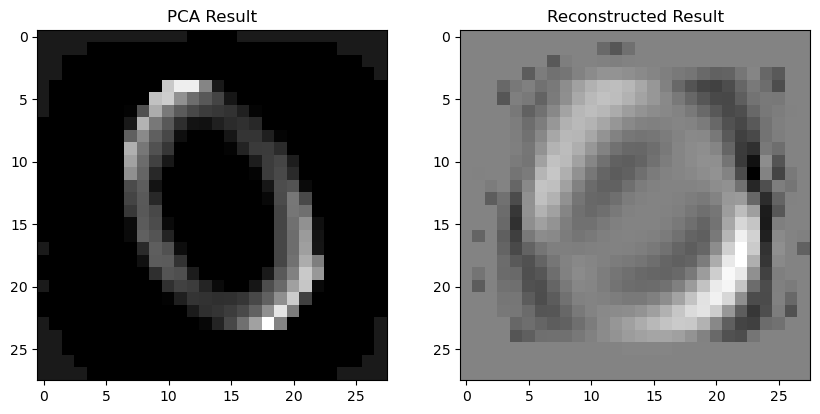

In [17]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(label_datasets_train[0][0].reshape(28, 28), cmap='gray')
plt.title('PCA Result')

plt.subplot(2, 2, 2)
plt.imshow(reconstructed_example2[0].reshape(28, 28), cmap='gray')
plt.title('Reconstructed Result')

plt.show()

**주어진 n_components_list에 다양한 Principal Component의 수를 적용하면서 Reconstruction 결과를 확인해보세요!**


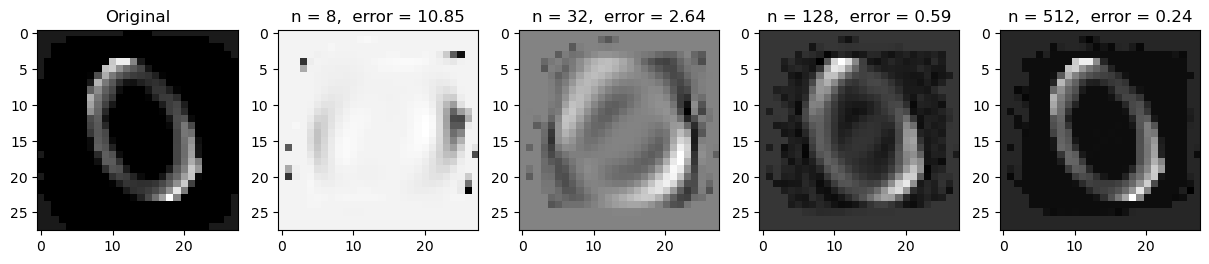

In [21]:
n_components_list = [8, 32, 128, 512]

fig, axs = plt.subplots(1, len(n_components_list) + 1, figsize=(15, 5))

# Original image
axs[0].imshow(label_datasets_train[0][0].reshape(28, 28), cmap='gray')
axs[0].set_title('Original')

for i, n_components in enumerate(n_components_list):
    pca_example, explained_variance = compute_pca(label_datasets_train[0], n_components)
    reconstructed_example, error = pca_reconstruction(label_datasets_train[0], pca_example)

    axs[i+1].imshow(reconstructed_example[0].reshape(28, 28), cmap='gray')
    axs[i+1].set_title(f'n = {n_components},  error = {error:.2f}')

plt.show()

## 5. MNIST Classification via PCA Reconstruction Error


앞서 #4에서 살펴본 Reconstruction Error에 대해 다시 생각해보겠습니다.

MNIST 데이터셋을 기준으로, Label이 0인 데이터셋에 대해 Principal Component를 구했다고 해봅시다.

구한 Principal Component를 이용해 Reconstruction을 진행한다면, 1에 대한 데이터와 0에 대한 데이터 중 무엇이 Error가 더 낮을까요?

Principal Component를 구하는 과정에서 사용한 Label에서 훨씬 Error가 낮기에, 이점을 이용해서 Classification Task를 수행해 볼 수 있습니다.

<hr/>


In [22]:
# PCA on each label
n_components = 32
label_pcas = {}
for label in range(10):
    label_pcas[label], _ = compute_pca(label_datasets_train[label], n_components)

_아래 predicted_label의 TODO에서 수행할 작업은 아래와 같습니다_

1. X dataset에서 각각의 데이터를 구해둔 label_pcas를 기준으로 pca_reconstruction을 진행.

2. 각 label_pcas에서 error를 비교하여 가장 작은 error를 보인 label을 predicted_labels 리스트에 append.

3. 전체 함수는 predicted_labels를 반환.

<hr/>


In [25]:
# Prediction function
def predict_label(X, label_pcas):

    error_list = np.full((X.shape[0], 10), np.inf)

    for i in range(X.shape[0]):
        for j in label_pcas.keys():
            _, error_list[i, j] = pca_reconstruction(X[i], label_pcas[j])

    predicted_labels = np.argmin(error_list, axis = 1)

    return predicted_labels

In [ ]:
predicted_labels = predict_label(X_test, label_pcas)

# Compute accuracy
accuracy = np.mean(np.array(predicted_labels) == y_test)
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Confusion Matrix Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## 6. Your Work!


앞서 수행한 reconstruction error based classification에는 다양한 hyperparameter들이 있습니다.

다양하게 hyperparmeter들을 변경해보면서 Prinicpal Component의 수와 classification의 정확도 사이에 어떤 상관관계가 있는지 자유롭게 분석해보세요.


In [ ]:
n_components_list = [8, 32, 128, 512]
accuracies = []

for n in n_components_list:
    label_pcas = {}

    # 각 레이블별 PCA 수행
    for label in range(10):
        label_pcas[label], _ = compute_pca(label_datasets_train[label], n)
    
    # 예측 라벨 생성
    predicted_labels = predict_label(X_test, label_pcas)

    # 정확도 계산
    accuracy = np.mean(np.array(predicted_labels) == y_test)
    accuracies.append(accuracy)

    print(f"Number of principal components for reconstruction : {n}")
    print(f"Accuracy on test set: {accuracy * 100:.2f}%\n")

In [ ]:
# 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(n_components_list, accuracies, marker='o')
plt.title('Number of Principal Components vs. Classification Accuracy')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()